In [308]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from PIL import Image
import time
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

from torchsummary import summary

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Check cuda version in cmd
# nvcc --version
# Check GPU in cmd
# nvidia-smi

In [309]:
# Setup device-agnostic code
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [310]:
# Check PyTorch version
print("PyTorch version:", torch.__version__)
# Show Cuda GPU device
print(torch.cuda.get_device_name(0))
print(torch.cuda.get_arch_list())
print(torch.backends.cudnn.version())

PyTorch version: 2.0.1
NVIDIA GeForce GTX 1050 Ti
['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90', 'compute_37']
8700


In [311]:
# GOOGLE COLAB

# Import dataset from gdrive

# from google.colab import drive
# drive.mount('/content/drive')
# !pwd

# Open one image from the dataset (Google Colab)

# path = "drive/My Drive/Master/dataset/"
# with Image.open(path + 'frost/3600.jpg') as img:
#     print("\t")
#     display(img)

In [312]:
# Set the random seed for CPU operations
seed = 16
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Check if CUDA is available and set the random seed for GPU operations
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

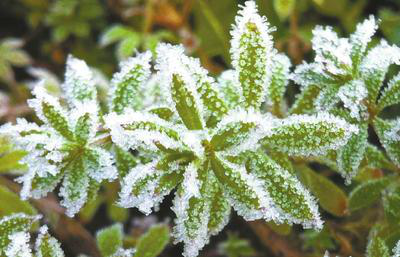

In [313]:
# Open one image from the dataset (Locally)
path = 'dataset'
with Image.open(path + '/frost/3600.jpg') as img:
    display(img)

In [314]:
# Create ImageFolder Dataset
dataset = datasets.ImageFolder(path, transform=None)
dataset

Dataset ImageFolder
    Number of datapoints: 6862
    Root location: dataset

In [315]:
# Display number of classes in the dataset
classes = dataset.classes
print(classes)
print("\t")
print("Number of classes:", len(classes))

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
	
Number of classes: 11


## Convert dataset into CSV file

In [316]:
# List to store image paths and corresponding labels
data = []

# Loop through each label directory
for label_name in os.listdir(path):
    label_dir = os.path.join(path, label_name)
    if os.path.isdir(label_dir):
        # Loop through each image file in the label directory
        for filename in os.listdir(label_dir):
            if filename.endswith('.jpg'):
                image_path = os.path.join(label_dir, filename)
                label = label_name
                data.append((image_path, label))

# Convert the data list into a Pandas DataFrame
df = pd.DataFrame(data, columns=['image_path', 'label'])

# Save the DataFrame to a CSV file
csv_file = 'dataset.csv'  # Change the filename if desired
df.to_csv(csv_file, index=False)

In [317]:
# Load csv file and show first 5 rows
df = pd.read_csv('dataset.csv')
df.head() 

,image_path,label
0,dataset\dew\2208.jpg,dew
1,dataset\dew\2209.jpg,dew
2,dataset\dew\2210.jpg,dew
3,dataset\dew\2211.jpg,dew
4,dataset\dew\2212.jpg,dew


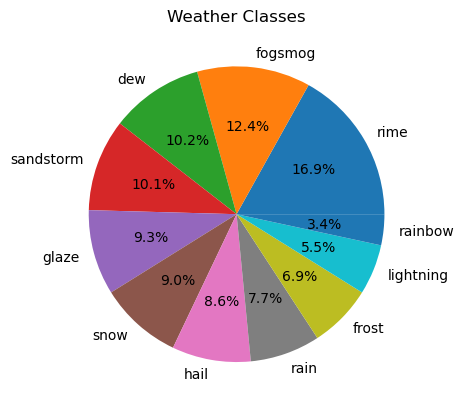

In [318]:
# Plot a pie chart to visualize % of each class in the dataset
label_counts = df["label"].value_counts()
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Weather Classes')
plt.show()

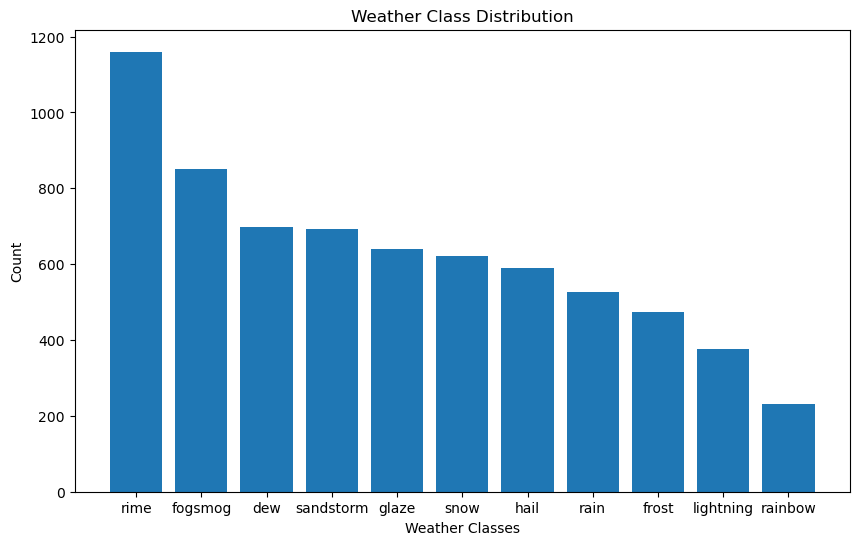

In [319]:
# Plot a bar chart to visualize the count of each class in the dataset
label_counts = df["label"].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(label_counts.index, label_counts)
plt.xlabel('Weather Classes')
plt.ylabel('Count')
plt.title('Weather Class Distribution')
plt.show()

## Split dataset into train, validation and test sets

In [320]:
# Split dataset into train and test
train_size_old = int(0.85 * len(dataset))
test_size = len(dataset) - train_size_old
train_data_old, test_data = torch.utils.data.random_split(dataset, [train_size_old, test_size])

# Split dataset to train and validation
train_size = int(0.85 * len(train_data_old))
val_size = len(train_data_old) - train_size
train_data, val_data = torch.utils.data.random_split(train_data_old, [train_size, val_size])

## Define transforms for each set

In [321]:
# Define the normalization values for mean and standard deviation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Training set transformations
train_transform = transforms.Compose([
    transforms.Resize((400,400)),
    transforms.RandomResizedCrop((256,256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    transforms.RandomAutocontrast(p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 3.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
train_data.dataset.transform = train_transform

# Validation set transformations
val_transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.CenterCrop((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
val_data.dataset.transform = val_transform

# Test set transformations
test_transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.CenterCrop((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_data.dataset.transform = test_transform

## Create initial data loaders for each set of data

In [322]:
# Define initial batch size, before hyperparameter tuning
batch = 32

# Define initial Data loaders, before hyperparameter tuning
train_loader = DataLoader(train_data, batch_size=batch, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch, pin_memory=True, shuffle=False)

# Define variables for sizes of each set
train_data_len = len(train_data)
val_data_len = len(val_data)
test_data_len = len(test_data)

print("Training images available:", train_data_len)
print("\t")
print("Validation images available:", val_data_len)
print("\t")
print("Testing images available:", test_data_len)

Training images available: 4957
	
Validation images available: 875
	
Testing images available: 1030


In [323]:
# Display one tensor from train data
train_data[0]

(tensor([[[-1.7412, -1.7583, -1.7583,  ..., -0.6281, -0.6794, -0.6965],
          [-1.7412, -1.7583, -1.7583,  ..., -0.6452, -0.6794, -0.7137],
          [-1.7583, -1.7754, -1.7754,  ..., -0.6452, -0.6965, -0.7308],
          ...,
          [-0.7650, -0.6452, -0.5938,  ..., -1.6555, -1.6727, -1.6555],
          [-0.8678, -0.7137, -0.6109,  ..., -1.6555, -1.6555, -1.6555],
          [-1.1589, -0.8164, -0.6452,  ..., -1.6727, -1.6727, -1.6555]],
 
         [[-1.4230, -1.4405, -1.4230,  ...,  0.1176,  0.1001,  0.0826],
          [-1.4230, -1.4405, -1.4230,  ...,  0.1001,  0.1001,  0.0826],
          [-1.4405, -1.4405, -1.4230,  ...,  0.1001,  0.0826,  0.0826],
          ...,
          [-0.0574,  0.1527,  0.1702,  ..., -1.3529, -1.3704, -1.3354],
          [-0.1975,  0.1001,  0.1527,  ..., -1.3354, -1.3529, -1.3529],
          [-0.5651, -0.0224,  0.1176,  ..., -1.3354, -1.3529, -1.3354]],
 
         [[-1.7173, -1.7347, -1.7347,  ..., -1.3339, -1.3513, -1.4036],
          [-1.7173, -1.7347,

Class Indexes:
['frost', 'rime', 'hail', 'sandstorm', 'fogsmog', 'fogsmog', 'lightning', 'sandstorm', 'rime', 'hail', 'snow', 'dew', 'fogsmog', 'frost', 'hail', 'lightning']
	
Sample image size: torch.Size([3, 256, 256])
	


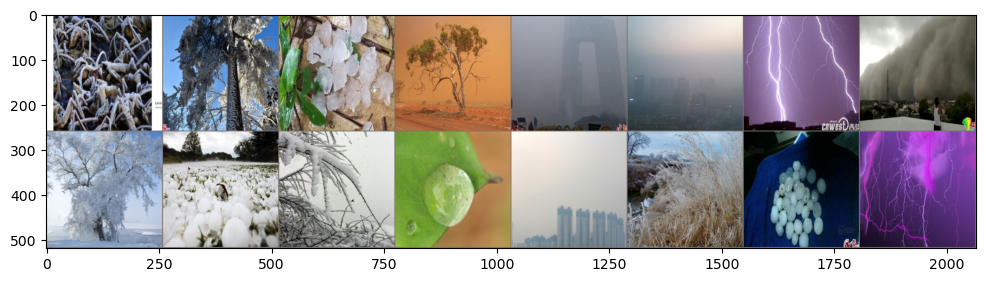

In [324]:
# Grab the first batch of images
for images, labels in train_loader: 
    break
    
# Extract the first 16 images
images_subset = images[:16]
labels_subset = labels[:16]

class_index_to_label = {
    0: 'dew',
    1: 'fogsmog',
    2: 'frost',
    3: 'glaze',
    4: 'hail',
    5: 'lightning',
    6: 'rain',
    7: 'rainbow',
    8: 'rime',
    9: 'sandstorm',
    10: 'snow'
}

# Map indexes to labels
labels = [class_index_to_label[i] for i in labels_subset.numpy()]

# Print the labels
print('Class Indexes:')
print(labels)
print("\t")

# Make a grid with 8 images in each row
im = make_grid(images_subset, nrow=8)

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

# Check one image shape
print("Sample image size:", images_subset[0].shape)
print("\t")

# Define functions

## Count number of trainable parameters

In [325]:
def count_parameters(model):
    
    print("Total sum of trainable weights in the model:")
    print("\t")
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

## Move model and optimizer to GPU

In [326]:
def move_model_and_optimizer_to_gpu(model, optimizer):
    
    # Move model to cuda device
    model.to(device)
    next(model.parameters()).is_cuda
    
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)

## Hyperparameter tuning

In [327]:
def hyperparameter_tuning(model, learning_rates, batch_sizes, l1_lambdas, l2_lambdas, model_name):

    start_time = time.time()
    model_name = model_name

    best_lr = None
    best_batch_size = None
    best_l1 = None
    best_l2 = None
    best_accuracy = 0.0
    epochs = 200

    
    # Define hyperparameter loops
    for lr in learning_rates:
        for batch in batch_sizes:
            for l1 in l1_lambdas:
                for l2 in l2_lambdas:
                    
                    # Set train and val loaders for different batch values
                    train_loader = DataLoader(train_data, batch_size=batch, pin_memory=True, shuffle=True)
                    val_loader = DataLoader(val_data, batch_size=batch, pin_memory=True, shuffle=False)

                    if model_name == "ShuffleNet":
                        model = models.shufflenet_v2_x2_0(pretrained=True)
                        for param in model.parameters():
                            param.requires_grad = False
                        model.fc = nn.Linear(2048, 11)
                        
                        # Set different learning rates and l2 lambdas for optimizer
                        optimizer = torch.optim.AdamW(model.fc.parameters(), lr=lr, weight_decay=l2)
                    else:
                        print("Model does not match")

                    criterion = nn.CrossEntropyLoss()       

                    # Move optimizer state to the GPU
                    move_model_and_optimizer_to_gpu(model, optimizer)

                    print("\t")
                    print(f"training {model_name} with learning rate:", lr, "batch size:", batch, "L1:", l1, "L2:", l2)
                    print("_________________________________________________________________________")
                    print("\t")

                    # Define patience, counter, best validation accuracy and
                    # a boolean value that determines if early stop mechanism is to be activated
                    patience = 10
                    counter = 0
                    best_val_acc = 0
#                     best_train_acc = 0.0
                    is_early_stop = False

                    # For each epoch run the training and validation bathes
                    for epoch in range(epochs):
                        train_corr = 0
                        val_corr = 0

                        # Run the training batches
                        model.train()
                        
                        for images, labels in train_loader:

                            # Move images and labels to device
                            images = images.to(device)
                            labels = labels.to(device)

                            # Apply the model for training
                            outputs = model(images)
                            # Number of losses
                            loss = criterion(outputs, labels)

                            # Number of correct predictions
                            predicted = torch.max(outputs.data, 1)[1]
                            train_corr += (predicted == labels).sum()
                            
                            # L1 regularization term calculation
                            l1_reg = torch.tensor(0.).to(device)
                            for param in model.fc.parameters():
                                l1_reg += torch.norm(param, p=1)

                            # Calculate the total loss with L1 regularization
                            total_loss = loss + l1 * l1_reg

                            # Update parameters during training
                            optimizer.zero_grad()
                            total_loss.backward()
                            optimizer.step()

                        # Calculate accuracy after each epoch
                        accuracy_train = round(train_corr.item() * 100 / train_data_len, 3)
                        
                        # Update best training accuracy if higher
#                         if accuracy_train > best_train_accuracy:
#                             best_train_acc = accuracy_train                        

                        # Print each epoch results
                        print("Epoch:", epoch + 1, "Train loss:", round(loss.item(), 3), 
                              "Train accuracy:", accuracy_train, "%")




                        # Run the validation batches
                        model.eval()

                        with torch.no_grad():
                            for images, labels in val_loader:

                                # Move images and labels to device
                                images = images.to(device)
                                labels = labels.to(device)

                                # Apply the model for validation
                                outputs = model(images)
                                # Number of losses
                                loss = criterion(outputs, labels)

                                # Number of correct predictions
                                predicted = torch.max(outputs.data, 1)[1] 
                                val_corr += (predicted == labels).sum()

                            # Calculate accuracy after each epoch
                            accuracy_val = round(val_corr.item() * 100 / val_data_len, 3)    
                            


                            # Early stopping
                            if accuracy_val > best_val_acc:
                                best_val_acc = accuracy_val
                                counter = 0
                            else:
                                counter += 1

                            # Check for early stopping after the validation loop    
                            if counter >= patience:
                                is_early_stop = True
                                print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3), 
                                      "Validation accuracy:", accuracy_val, "%")            
                                print("Early stopping triggered. Training stopped.")
                                break


                        if is_early_stop:
                            break
                        else:
                            # Print each epoch results
                            print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3), 
                                  "Validation accuracy:", accuracy_val, "%")
                            print("best_val_acc:", round(best_val_acc, 3), "counter:", counter)
                            print("\t")


                            
#                     print("For this hyperparameter combination, best training accuracy is:", best_train_acc,
#                           "and best validation accuracy is:" best_val_acc)        
                            
                    # Check if the current hyperparameters achieved better accuracy
                    if best_val_acc > best_accuracy:
                        best_accuracy = best_val_acc
                        best_lr = lr
                        best_batch_size = batch
                        best_l1 = l1
                        best_l2 = l2
                        print("Current best Hyperparameters: Learning Rate:", best_lr, "Batch Size:", best_batch_size,
                              "L1:", best_l1, "L2:", best_l2, "Validation accuracy:", best_accuracy)


    print("\n")
    print("Best Hyperparameters overall: Learning Rate:", best_lr, "Batch Size:", best_batch_size,
          "L1:", best_l1, "L2:", best_l2,"Validation accuracy:", best_accuracy)
    print("\t")
    print("Duration:", round(time.time() - start_time, 1), "seconds")

## Train and validate model

In [328]:
def train_and_val_model(model, criterion, optimizer, train_loader, val_loader, model_name,
                        train_loss_list, train_corr_list, val_loss_list, val_corr_list):
    
    start_time = time.time()
    # Number of epochs
    epochs = 200
    
    model_name = model_name

    # Define patience, counter, best validation accuracy and
    # a boolean value that determines if early stop mechanism is to be activated
    patience = 10
    counter = 0
    best_val_acc = 0
    is_early_stop = False


    # For each epoch run the training and validation bathes
    for epoch in range(epochs):
        train_corr = 0
        val_corr = 0

        # Run the training batches
        model.train()
        
        for images, labels in train_loader:

            # Move images and labels to device
            images = images.to(device)
            labels = labels.to(device)

            # Apply the model for training
            outputs = model(images)
            # Number of losses
            loss = criterion(outputs, labels)

            # Number of correct predictions
            predicted = torch.max(outputs.data, 1)[1]
            train_corr += (predicted == labels).sum()
            
            # L1 regularization term calculation
            l1_reg = torch.tensor(0.).to(device)
            for param in model.fc.parameters():
                l1_reg += torch.norm(param, p=1)

            # Calculate the total loss with L1 regularization
            total_loss = loss + l1_lambda * l1_reg

            # Update parameters during training
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

        # Append losses and correct predictions per epoch
        train_loss_list.append(loss)
        train_corr_list.append(train_corr)

        # Calculate accuracy after each epoch
        accuracy_train = round(train_corr.item() * 100 / train_data_len, 3)

        # Print each epoch results
        print("Epoch:", epoch + 1, "Train loss:", round(loss.item(), 3),
              "Train accuracy:", accuracy_train, "%")




        # Run the validation batches
        model.eval()

        with torch.no_grad():
            for images, labels in val_loader:

                # Move images and labels to device
                images = images.to(device)
                labels = labels.to(device)

                # Apply the model for validation
                outputs = model(images)
                # Number of losses
                loss = criterion(outputs, labels)

                # Number of correct predictions
                predicted = torch.max(outputs.data, 1)[1]
                val_corr += (predicted == labels).sum()

            # Calculate accuracy after each epoch
            accuracy_val = round(val_corr.item() * 100 / val_data_len, 3)



            # Early stopping
            if accuracy_val > best_val_acc:
                best_val_acc = accuracy_val
                counter = 0

                # Save model with best accuracy
                torch.save(model.state_dict(), f"Best{model_name}.pt")
            else:
                counter += 1

            # Check for early stopping after the validation loop
            if counter >= patience:
                is_early_stop = True
                print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3),
                      "Validation accuracy:", accuracy_val, "%")
                print("Early stopping triggered. Training stopped.")
                break


        # Append losses and correct predictions per epoch
        val_loss_list.append(loss)
        val_corr_list.append(val_corr)

        if is_early_stop:
            break
        else:
            # Print each epoch results
            print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3),
                  "Validation accuracy:", accuracy_val, "%")
            print("best_val_acc:", round(best_val_acc, 3), "counter:", counter)
            print("\t")


    print("\n")
    print("Duration:", round(time.time() - start_time, 1), "seconds")

## Test model

In [329]:
accuracy_global = 0.0

def test_model(model_best, criterion, test_loader, test_corr_list):

    global accuracy_global
    test_corr = 0

    # Run the test batches
    model_best.eval()

    with torch.no_grad():
        for images, labels in test_loader:

            # Move images and labels to device
            images = images.to(device)
            labels = labels.to(device)

            # Apply the model for validation
            outputs = model_best(images)
            # Number of losses
            loss = criterion(outputs, labels)

            # Number of correct predictions
            predicted = torch.max(outputs.data, 1)[1]
            test_corr += (predicted == labels).sum()

        # Calculate accuracy
        accuracy = round(test_corr.item() * 100 / test_data_len, 3)

    test_corr_list.append(test_corr)
    accuracy_global = accuracy

## Confusion Matrix

In [330]:
def show_confusion_matrix(model_best):
    
    # Create a loader for the entire test set
    test_load_all = DataLoader(test_data, batch_size=test_data_len, shuffle=False)
    
    # Move model to cpu
    model_best.cpu()

    with torch.no_grad():
        
        correct = 0
        predicted_labels = []
        true_labels = []
        
        for images, labels in test_load_all:

            # Move images and labels to cpu
            images = images.cpu()
            labels = labels.cpu()

            outputs = model_best(images)
            predicted = torch.max(outputs, 1)[1]
            correct += (predicted == labels).sum()
            
            # Append predicted and true labels to lists
            predicted_labels.extend(predicted.tolist())
            true_labels.extend(labels.tolist())

    arr = confusion_matrix(true_labels, predicted_labels)
    df_cm = pd.DataFrame(arr, classes, classes)
    
    # Call cm_metrics function to calculate confusion matrix metrics
    cm_metrics(true_labels, predicted_labels)

    # Plot the confusion matrix
    plt.figure(figsize = (9,6))
    sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show();

## Calculate Confusion Matrix metrics

In [331]:
def cm_metrics(true, predicted):

    TP = {}
    FP = {}
    TN = {}
    FN = {}

    for class_label in range(len(classes)):
        TP[class_label] = 0
        FP[class_label] = 0
        TN[class_label] = 0
        FN[class_label] = 0

    # Calculate TP, FP, TN, FN for each class
    for i in range(len(predicted)):
        if true[i] == predicted[i]:
            TP[true[i]] += 1
            for class_label in range(len(classes)):
                if class_label != true[i]:
                    TN[class_label] += 1
        else:
            FP[predicted[i]] += 1
            FN[true[i]] += 1
            for class_label in range(len(classes)):
                if class_label != true[i] and class_label != predicted[i]:
                    TN[class_label] += 1

    precision = {}
    recall = {}
    f1_score = {}

    # Calculate precision, recall and f1 score for each class
    for class_label in range(len(classes)):
        precision[class_label] = TP[class_label] / (TP[class_label] + FP[class_label])
        recall[class_label] = TP[class_label] / (TP[class_label] + FN[class_label])
        f1_score[class_label] = 2 * (precision[class_label] * recall[class_label]) / (precision[class_label]
                                                                                      + recall[class_label])

    # Calculate overall accuracy
    accuracy = accuracy_score(true, predicted)

    # Calculate micro, macro, weighted values of precision, recall and f1 score
    macro_precision, macro_recall, macro_f1_score, support = precision_recall_fscore_support(
        true, predicted, average='macro')
    micro_precision, micro_recall, micro_f1_score, support = precision_recall_fscore_support(
        true, predicted, average='micro')
    weighted_precision, weighted_recall, weighted_f1_score, support = precision_recall_fscore_support(
        true, predicted, average='weighted')

    
    print("**********************")
    print("Individual Class Metrics:")
    print("**********************")
    print("\t")
    
    for class_label in range(len(classes)):
        print("Class:", class_label)
        print("---------------------")
        print("True Positive (TP):", round(TP[class_label], 3))
        print("True Negative (TN):", round(TN[class_label], 3))
        print("False Positive (FP):", round(FP[class_label], 3))
        print("False Negative (FN):", round(FN[class_label], 3))
        print("Precision:", round(precision[class_label], 3))
        print("Recall:", round(recall[class_label], 3))
        print("F1 Score:", round(f1_score[class_label], 3))
        print("\t")  
    
    print("\n")
    print("**********************")
    print("Average Metrics:")
    print("**********************")
    print("\t")
    print("Total Accuracy:", round(accuracy, 3))
    print("---------------------")
    print("Macro-Averaged Precision:", round(macro_precision, 3))
    print("Macro-Averaged Recall:", round(macro_recall, 3))
    print("Macro-Averaged F1 Score:", round(macro_f1_score, 3))
    print("---------------------")
    print("Micro-Averaged Precision:", round(micro_precision, 3))
    print("Micro-Averaged Recall:", round(micro_recall, 3))
    print("Micro-Averaged F1 Score:", round(micro_f1_score, 3))
    print("---------------------")
    print("Weighted-Averaged Precision:", round(weighted_precision, 3))
    print("Weighted-Averaged Recall:", round(weighted_recall, 3))
    print("Weighted-Averaged F1 Score:", round(weighted_f1_score, 3))
    print("\t")

## Individual class performance

In [332]:
def class_performance(model, test_loader):
    
    # Prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # Again no gradients needed
    with torch.no_grad():
        for images, labels in test_loader:
            
            # Move images and labels to device
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            predictions = torch.max(outputs, 1)[1]
            
            # Collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # Print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:10s} {accuracy:.2f} %')

## Model prediction on single image

In [333]:
def custom_img_prediction(img_path): 
    
    # Open a custom image
    custom_img = Image.open('custom_images/' + img_path)

    # Define transforms for the image
    transform_custom = transforms.Compose([
            transforms.Resize((300,300)),
            transforms.CenterCrop((256,256)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])

    # Apply transforms to the image
    custom_img_t = transform_custom(custom_img)
    print("Custom image size:", custom_img_t.shape)

    # Inverse normalize the image
    custom_img_n = inv_normalize(custom_img_t)
    plt.imshow(np.transpose(custom_img_n.numpy(), (1, 2, 0)));
    print("\t")

    # Call the model prediction function
    load_model_to_predict_custom_img(ShuffleNet_best, "ShuffleNet", classes, custom_img_t)
    print("\t")

In [334]:
def load_model_to_predict_custom_img(model_best, model_name, classes, custom_img_t):
    
    model_name = model_name
    model_best.cpu()
    
    model_best.eval()
    with torch.no_grad():
        output = model_best(custom_img_t.view(1, 3, 256, 256))
        probabilities = torch.softmax(output, dim=1)
        percentage_values = probabilities * 100

    # Extract the predicted class
    predicted_class = torch.argmax(probabilities, dim=1).item()
    
    # Plotting the values
    plt.figure(figsize=(10, 6))
    plt.bar(classes, percentage_values[0].numpy())
    plt.xlabel('Classes')
    plt.ylabel('Percentage')
    plt.title('Percentage of Guesses')
    plt.show() 

    # Display the predicted class and corresponding percentage
    print(f"{model_name} model prediction: {classes[predicted_class]}")
    print("\t")
    print("Percentage of Guesses:")
    for i, class_label in enumerate(classes):
        print(f"{class_label:10s} {percentage_values[0, i]:.2f}%")   

# ShuffleNet

In [296]:
ShuffleNet = models.shufflenet_v2_x2_0(pretrained=True)
ShuffleNet

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_runn

In [297]:
# Freeze the pre-trained layers to prevent their weights from being updated
for param in ShuffleNet.parameters():
    param.requires_grad = False

In [298]:
# We modified the last layer in the model, so that the output matches the number of classes in our dataset
ShuffleNet.fc = nn.Linear(2048, 11)

In [299]:
summary(ShuffleNet.to(device), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 128, 128]             648
       BatchNorm2d-2         [-1, 24, 128, 128]              48
              ReLU-3         [-1, 24, 128, 128]               0
         MaxPool2d-4           [-1, 24, 64, 64]               0
            Conv2d-5           [-1, 24, 32, 32]             216
       BatchNorm2d-6           [-1, 24, 32, 32]              48
            Conv2d-7          [-1, 122, 32, 32]           2,928
       BatchNorm2d-8          [-1, 122, 32, 32]             244
              ReLU-9          [-1, 122, 32, 32]               0
           Conv2d-10          [-1, 122, 64, 64]           2,928
      BatchNorm2d-11          [-1, 122, 64, 64]             244
             ReLU-12          [-1, 122, 64, 64]               0
           Conv2d-13          [-1, 122, 32, 32]           1,098
      BatchNorm2d-14          [-1, 122,

In [300]:
# Count the number of trainable parameters
count_parameters(ShuffleNet)

Total sum of trainable weights in the model:
	
   22528
      11
________
   22539


In [301]:
# Define initial loss and optimization functions, before hyperparameter tuning
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(ShuffleNet.fc.parameters(), lr=0.001)

In [302]:
# Move model and optimizer to cuda
move_model_and_optimizer_to_gpu(ShuffleNet, optimizer)

True


## Hyperparameter tuning

In [303]:
# Define hyperparameters that we want to tune
learning_rates = [0.001, 0.01]
batch_sizes = [64, 128]
l1_lambdas = [0.0001, 0.001]
l2_lambdas = [0.0001, 0.001]

# Call the hyperparameter tuning function
hyperparameter_tuning(ShuffleNet, learning_rates, batch_sizes, l1_lambdas, l2_lambdas, "ShuffleNet")

True
	
training ShuffleNet with learning rate: 0.001 batch size: 64 L1: 0.0001 L2: 0.0001
_________________________________________________________________________
	
Epoch: 1 Train loss: 0.563 Train accuracy: 71.878 %
Epoch: 1 Validation loss: 0.629 Validation accuracy: 81.943 %
best_val_acc: 81.943 counter: 0
	
Epoch: 2 Train loss: 0.535 Train accuracy: 86.827 %
Epoch: 2 Validation loss: 0.53 Validation accuracy: 86.743 %
best_val_acc: 86.743 counter: 0
	
Epoch: 3 Train loss: 0.343 Train accuracy: 89.348 %
Epoch: 3 Validation loss: 0.497 Validation accuracy: 87.543 %
best_val_acc: 87.543 counter: 0
	
Epoch: 4 Train loss: 0.261 Train accuracy: 90.861 %
Epoch: 4 Validation loss: 0.52 Validation accuracy: 89.029 %
best_val_acc: 89.029 counter: 0
	
Epoch: 5 Train loss: 0.34 Train accuracy: 91.668 %
Epoch: 5 Validation loss: 0.489 Validation accuracy: 90.286 %
best_val_acc: 90.286 counter: 0
	
Epoch: 6 Train loss: 0.152 Train accuracy: 92.879 %
Epoch: 6 Validation loss: 0.491 Validation ac

Epoch: 17 Validation loss: 0.528 Validation accuracy: 90.514 %
best_val_acc: 91.086 counter: 6
	
Epoch: 18 Train loss: 0.083 Train accuracy: 96.752 %
Epoch: 18 Validation loss: 0.519 Validation accuracy: 91.086 %
best_val_acc: 91.086 counter: 7
	
Epoch: 19 Train loss: 0.166 Train accuracy: 97.115 %
Epoch: 19 Validation loss: 0.557 Validation accuracy: 90.629 %
best_val_acc: 91.086 counter: 8
	
Epoch: 20 Train loss: 0.256 Train accuracy: 97.398 %
Epoch: 20 Validation loss: 0.521 Validation accuracy: 90.743 %
best_val_acc: 91.086 counter: 9
	
Epoch: 21 Train loss: 0.114 Train accuracy: 97.519 %
Epoch: 21 Validation loss: 0.525 Validation accuracy: 90.629 %
Early stopping triggered. Training stopped.
True
	
training ShuffleNet with learning rate: 0.001 batch size: 64 L1: 0.001 L2: 0.0001
_________________________________________________________________________
	
Epoch: 1 Train loss: 0.826 Train accuracy: 72.826 %
Epoch: 1 Validation loss: 0.646 Validation accuracy: 82.971 %
best_val_acc: 

Epoch: 13 Validation loss: 0.484 Validation accuracy: 89.029 %
best_val_acc: 89.486 counter: 8
	
Epoch: 14 Train loss: 0.408 Train accuracy: 91.124 %
Epoch: 14 Validation loss: 0.5 Validation accuracy: 88.914 %
best_val_acc: 89.486 counter: 9
	
Epoch: 15 Train loss: 0.238 Train accuracy: 91.87 %
Epoch: 15 Validation loss: 0.507 Validation accuracy: 88.571 %
Early stopping triggered. Training stopped.
True
	
training ShuffleNet with learning rate: 0.001 batch size: 128 L1: 0.0001 L2: 0.0001
_________________________________________________________________________
	
Epoch: 1 Train loss: 0.864 Train accuracy: 65.624 %
Epoch: 1 Validation loss: 0.766 Validation accuracy: 83.543 %
best_val_acc: 83.543 counter: 0
	
Epoch: 2 Train loss: 0.498 Train accuracy: 85.959 %
Epoch: 2 Validation loss: 0.582 Validation accuracy: 86.971 %
best_val_acc: 86.971 counter: 0
	
Epoch: 3 Train loss: 0.398 Train accuracy: 88.562 %
Epoch: 3 Validation loss: 0.538 Validation accuracy: 86.971 %
best_val_acc: 86.97

Epoch: 22 Validation loss: 0.481 Validation accuracy: 91.086 %
best_val_acc: 91.2 counter: 4
	
Epoch: 23 Train loss: 0.126 Train accuracy: 97.7 %
Epoch: 23 Validation loss: 0.477 Validation accuracy: 91.086 %
best_val_acc: 91.2 counter: 5
	
Epoch: 24 Train loss: 0.121 Train accuracy: 97.68 %
Epoch: 24 Validation loss: 0.482 Validation accuracy: 90.971 %
best_val_acc: 91.2 counter: 6
	
Epoch: 25 Train loss: 0.217 Train accuracy: 97.579 %
Epoch: 25 Validation loss: 0.485 Validation accuracy: 91.086 %
best_val_acc: 91.2 counter: 7
	
Epoch: 26 Train loss: 0.083 Train accuracy: 98.043 %
Epoch: 26 Validation loss: 0.492 Validation accuracy: 91.086 %
best_val_acc: 91.2 counter: 8
	
Epoch: 27 Train loss: 0.154 Train accuracy: 98.063 %
Epoch: 27 Validation loss: 0.473 Validation accuracy: 90.857 %
best_val_acc: 91.2 counter: 9
	
Epoch: 28 Train loss: 0.192 Train accuracy: 98.184 %
Epoch: 28 Validation loss: 0.478 Validation accuracy: 91.314 %
best_val_acc: 91.314 counter: 0
	
Epoch: 29 Train lo

Epoch: 12 Validation loss: 0.517 Validation accuracy: 88.686 %
best_val_acc: 89.486 counter: 4
	
Epoch: 13 Train loss: 0.377 Train accuracy: 91.648 %
Epoch: 13 Validation loss: 0.525 Validation accuracy: 89.143 %
best_val_acc: 89.486 counter: 5
	
Epoch: 14 Train loss: 0.379 Train accuracy: 91.547 %
Epoch: 14 Validation loss: 0.516 Validation accuracy: 89.257 %
best_val_acc: 89.486 counter: 6
	
Epoch: 15 Train loss: 0.326 Train accuracy: 91.81 %
Epoch: 15 Validation loss: 0.511 Validation accuracy: 89.371 %
best_val_acc: 89.486 counter: 7
	
Epoch: 16 Train loss: 0.372 Train accuracy: 91.83 %
Epoch: 16 Validation loss: 0.532 Validation accuracy: 88.686 %
best_val_acc: 89.486 counter: 8
	
Epoch: 17 Train loss: 0.373 Train accuracy: 92.052 %
Epoch: 17 Validation loss: 0.515 Validation accuracy: 89.257 %
best_val_acc: 89.486 counter: 9
	
Epoch: 18 Train loss: 0.265 Train accuracy: 91.931 %
Epoch: 18 Validation loss: 0.517 Validation accuracy: 89.6 %
best_val_acc: 89.6 counter: 0
	
Epoch: 19

Epoch: 8 Validation loss: 0.591 Validation accuracy: 89.029 %
best_val_acc: 90.514 counter: 5
	
Epoch: 9 Train loss: 0.076 Train accuracy: 96.974 %
Epoch: 9 Validation loss: 0.626 Validation accuracy: 89.257 %
best_val_acc: 90.514 counter: 6
	
Epoch: 10 Train loss: 0.173 Train accuracy: 97.115 %
Epoch: 10 Validation loss: 0.826 Validation accuracy: 87.429 %
best_val_acc: 90.514 counter: 7
	
Epoch: 11 Train loss: 0.149 Train accuracy: 96.187 %
Epoch: 11 Validation loss: 0.739 Validation accuracy: 89.257 %
best_val_acc: 90.514 counter: 8
	
Epoch: 12 Train loss: 0.033 Train accuracy: 96.712 %
Epoch: 12 Validation loss: 0.748 Validation accuracy: 88.457 %
best_val_acc: 90.514 counter: 9
	
Epoch: 13 Train loss: 0.147 Train accuracy: 97.034 %
Epoch: 13 Validation loss: 0.825 Validation accuracy: 89.714 %
Early stopping triggered. Training stopped.
True
	
training ShuffleNet with learning rate: 0.01 batch size: 64 L1: 0.001 L2: 0.0001
__________________________________________________________

Epoch: 11 Validation loss: 0.547 Validation accuracy: 90.4 %
best_val_acc: 90.4 counter: 1
	
Epoch: 12 Train loss: 0.08 Train accuracy: 98.205 %
Epoch: 12 Validation loss: 0.617 Validation accuracy: 89.714 %
best_val_acc: 90.4 counter: 2
	
Epoch: 13 Train loss: 0.083 Train accuracy: 98.709 %
Epoch: 13 Validation loss: 0.589 Validation accuracy: 90.514 %
best_val_acc: 90.514 counter: 0
	
Epoch: 14 Train loss: 0.094 Train accuracy: 98.346 %
Epoch: 14 Validation loss: 0.618 Validation accuracy: 89.714 %
best_val_acc: 90.514 counter: 1
	
Epoch: 15 Train loss: 0.078 Train accuracy: 98.709 %
Epoch: 15 Validation loss: 0.633 Validation accuracy: 89.371 %
best_val_acc: 90.514 counter: 2
	
Epoch: 16 Train loss: 0.071 Train accuracy: 98.83 %
Epoch: 16 Validation loss: 0.646 Validation accuracy: 89.029 %
best_val_acc: 90.514 counter: 3
	
Epoch: 17 Train loss: 0.048 Train accuracy: 98.507 %
Epoch: 17 Validation loss: 0.627 Validation accuracy: 90.4 %
best_val_acc: 90.514 counter: 4
	
Epoch: 18 Tra

Epoch: 1 Train loss: 0.581 Train accuracy: 80.694 %
Epoch: 1 Validation loss: 0.604 Validation accuracy: 87.314 %
best_val_acc: 87.314 counter: 0
	
Epoch: 2 Train loss: 0.354 Train accuracy: 89.328 %
Epoch: 2 Validation loss: 0.685 Validation accuracy: 85.829 %
best_val_acc: 87.314 counter: 1
	
Epoch: 3 Train loss: 0.407 Train accuracy: 88.905 %
Epoch: 3 Validation loss: 0.527 Validation accuracy: 86.629 %
best_val_acc: 87.314 counter: 2
	
Epoch: 4 Train loss: 0.322 Train accuracy: 90.377 %
Epoch: 4 Validation loss: 0.657 Validation accuracy: 84.686 %
best_val_acc: 87.314 counter: 3
	
Epoch: 5 Train loss: 0.293 Train accuracy: 89.308 %
Epoch: 5 Validation loss: 0.507 Validation accuracy: 87.771 %
best_val_acc: 87.771 counter: 0
	
Epoch: 6 Train loss: 0.38 Train accuracy: 89.49 %
Epoch: 6 Validation loss: 0.488 Validation accuracy: 88.457 %
best_val_acc: 88.457 counter: 0
	
Epoch: 7 Train loss: 0.288 Train accuracy: 90.902 %
Epoch: 7 Validation loss: 0.526 Validation accuracy: 88.229 %


## Set the best hyperparameters

In [232]:
# Set the best hyperparameters
batch_size = 128
lr = 0.001
l1_lambda = 0.0001
l2_lambda = 0.0001

# Define Data Loaders with the best hyperparameters
train_loader = DataLoader(train_data, batch_size=batch_size, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, pin_memory=True, shuffle=False)

# Define loss and optimization functions with the best hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(ShuffleNet.fc.parameters(), lr=lr, weight_decay=l2_lambda)

## Training model

In [233]:
# Define lists to append train and val losses and accuracy per epoch
train_loss_list = []
train_corr_list = []
val_loss_list = []
val_corr_list = []

# Call the training and validation function
train_and_val_model(ShuffleNet, criterion, optimizer, train_loader,
                    val_loader, "ShuffleNet",train_loss_list, train_corr_list,
                    val_loss_list, val_corr_list)

Epoch: 1 Train loss: 0.706 Train accuracy: 65.947 %
Epoch: 1 Validation loss: 0.811 Validation accuracy: 81.6 %
best_val_acc: 81.6 counter: 0
	
Epoch: 2 Train loss: 0.507 Train accuracy: 85.596 %
Epoch: 2 Validation loss: 0.609 Validation accuracy: 86.286 %
best_val_acc: 86.286 counter: 0
	
Epoch: 3 Train loss: 0.453 Train accuracy: 88.441 %
Epoch: 3 Validation loss: 0.55 Validation accuracy: 87.314 %
best_val_acc: 87.314 counter: 0
	
Epoch: 4 Train loss: 0.367 Train accuracy: 90.075 %
Epoch: 4 Validation loss: 0.522 Validation accuracy: 88.114 %
best_val_acc: 88.114 counter: 0
	
Epoch: 5 Train loss: 0.503 Train accuracy: 90.861 %
Epoch: 5 Validation loss: 0.521 Validation accuracy: 89.143 %
best_val_acc: 89.143 counter: 0
	
Epoch: 6 Train loss: 0.309 Train accuracy: 92.153 %
Epoch: 6 Validation loss: 0.498 Validation accuracy: 89.029 %
best_val_acc: 89.143 counter: 1
	
Epoch: 7 Train loss: 0.304 Train accuracy: 92.98 %
Epoch: 7 Validation loss: 0.477 Validation accuracy: 89.257 %
best

## Evaluate model

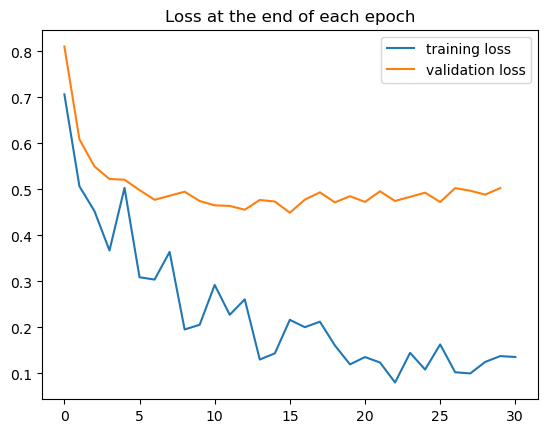

In [234]:
# Plot Losses per epoch
plt.plot([t.cpu().detach().numpy() for t in train_loss_list], label='training loss')
plt.plot([t.cpu().detach().numpy() for t in val_loss_list], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

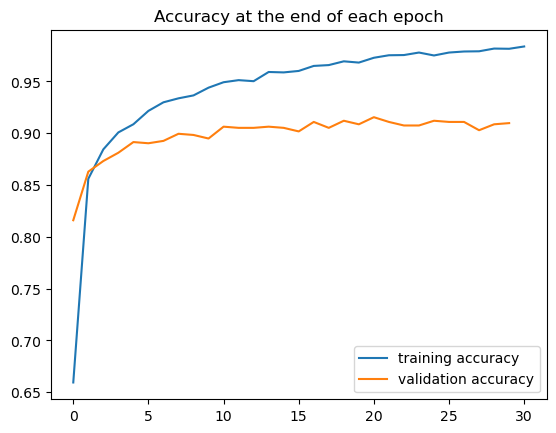

In [235]:
# Plot accuracy per epoch
plt.plot([t.cpu() / train_data_len for t in train_corr_list], label='training accuracy')
plt.plot([t.cpu() / val_data_len for t in val_corr_list], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [307]:
# How many accurate predictions were made per epoch for both train and val sets
print("Train Correct:")
print("-----------------")
print(train_corr_list)
print("-----------------")
print("Out of", train_data_len, "train set size")
print("\t")
print("Validation Correct:")
print("-----------------")
print(val_corr_list)
print("-----------------")
print("Out of", val_data_len, "train set size")

Train Correct:
-----------------
[tensor(3269, device='cuda:0'), tensor(4243, device='cuda:0'), tensor(4384, device='cuda:0'), tensor(4465, device='cuda:0'), tensor(4504, device='cuda:0'), tensor(4568, device='cuda:0'), tensor(4609, device='cuda:0'), tensor(4628, device='cuda:0'), tensor(4642, device='cuda:0'), tensor(4679, device='cuda:0'), tensor(4705, device='cuda:0'), tensor(4715, device='cuda:0'), tensor(4710, device='cuda:0'), tensor(4754, device='cuda:0'), tensor(4752, device='cuda:0'), tensor(4759, device='cuda:0'), tensor(4783, device='cuda:0'), tensor(4787, device='cuda:0'), tensor(4805, device='cuda:0'), tensor(4799, device='cuda:0'), tensor(4822, device='cuda:0'), tensor(4834, device='cuda:0'), tensor(4835, device='cuda:0'), tensor(4847, device='cuda:0'), tensor(4833, device='cuda:0'), tensor(4847, device='cuda:0'), tensor(4852, device='cuda:0'), tensor(4853, device='cuda:0'), tensor(4866, device='cuda:0'), tensor(4865, device='cuda:0'), tensor(4876, device='cuda:0')]
-----

## Load saved model 

In [236]:
ShuffleNet_best = models.shufflenet_v2_x2_0(pretrained=True)
ShuffleNet_best.fc = nn.Linear(2048, 11)
ShuffleNet_best.load_state_dict(torch.load('BestShuffleNet.pt'))

<All keys matched successfully>

In [237]:
move_model_and_optimizer_to_gpu(ShuffleNet_best, optimizer)

True


## Test the model

In [238]:
test_corr_list = []

# Call the test model function
test_model(ShuffleNet_best, criterion, test_loader, test_corr_list)

In [239]:
# Check how many correct predictions were made
print("Test Correct:", test_corr_list, "out of", test_data_len, "test set size")
# Print model accuracy on the test set
print("Test Accuracy:", accuracy_global, "%")

Test Correct: [tensor(937, device='cuda:0')]
Test Accuracy: 90.971 %


In [240]:
# Individual model class performance on the test set
class_performance(ShuffleNet_best, test_loader)

Accuracy for class: dew        95.74 %
Accuracy for class: fogsmog    94.78 %
Accuracy for class: frost      80.95 %
Accuracy for class: glaze      81.98 %
Accuracy for class: hail       98.82 %
Accuracy for class: lightning  98.08 %
Accuracy for class: rain       90.12 %
Accuracy for class: rainbow    100.00 %
Accuracy for class: rime       90.23 %
Accuracy for class: sandstorm  94.74 %
Accuracy for class: snow       81.82 %


## Confusion Matrix Metrics

**********************
Individual Class Metrics:
**********************
	
Class: 0
---------------------
True Positive (TP): 90
True Negative (TN): 928
False Positive (FP): 8
False Negative (FN): 4
Precision: 0.918
Recall: 0.957
F1 Score: 0.938
	
Class: 1
---------------------
True Positive (TP): 127
True Negative (TN): 884
False Positive (FP): 12
False Negative (FN): 7
Precision: 0.914
Recall: 0.948
F1 Score: 0.93
	
Class: 2
---------------------
True Positive (TP): 51
True Negative (TN): 955
False Positive (FP): 12
False Negative (FN): 12
Precision: 0.81
Recall: 0.81
F1 Score: 0.81
	
Class: 3
---------------------
True Positive (TP): 91
True Negative (TN): 902
False Positive (FP): 17
False Negative (FN): 20
Precision: 0.843
Recall: 0.82
F1 Score: 0.831
	
Class: 4
---------------------
True Positive (TP): 84
True Negative (TN): 944
False Positive (FP): 1
False Negative (FN): 1
Precision: 0.988
Recall: 0.988
F1 Score: 0.988
	
Class: 5
---------------------
True Positive (TP): 51
True N

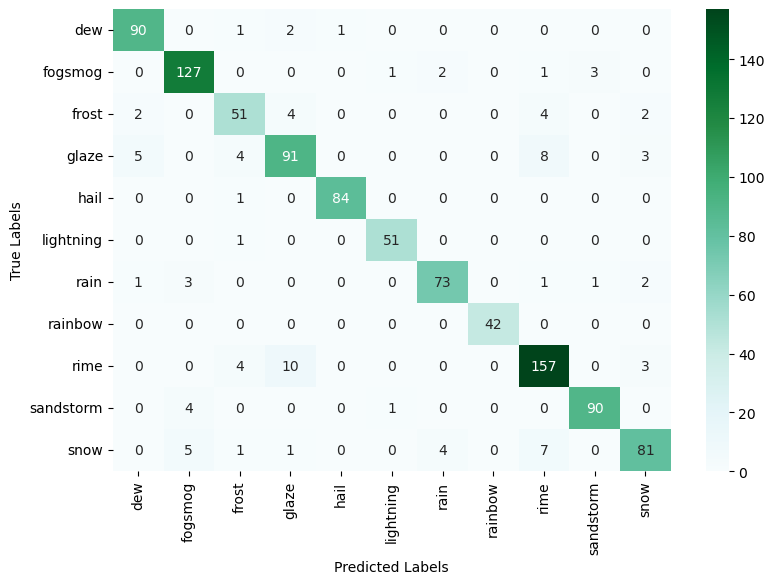

In [241]:
# Call the confusion matrix function
show_confusion_matrix(ShuffleNet_best)

## Open a custom image and use the models for prediction

Custom image size: torch.Size([3, 256, 256])
	


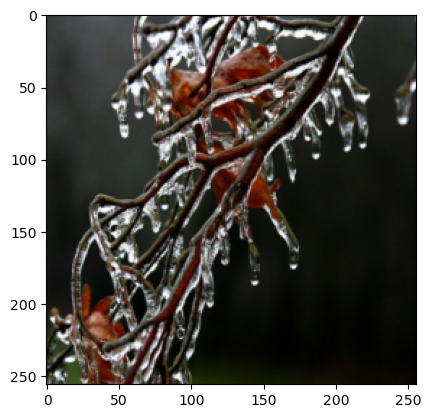

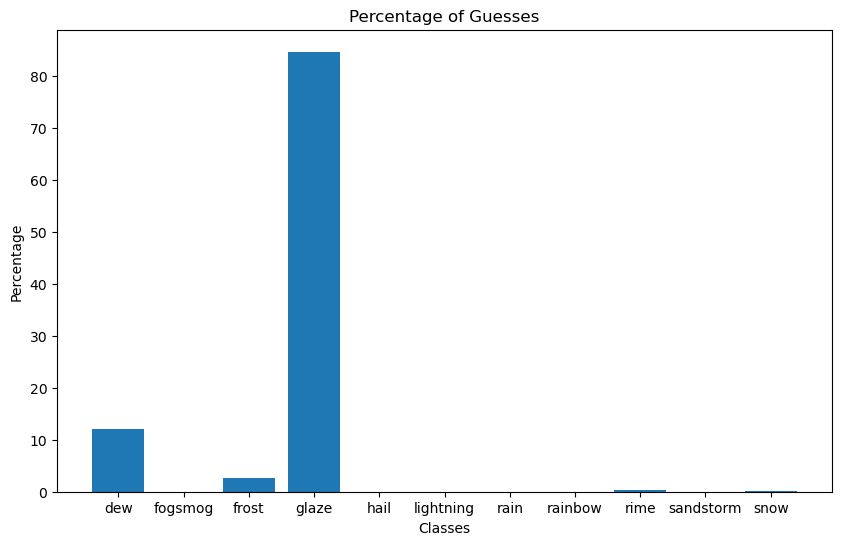

ShuffleNet model prediction: glaze
	
Percentage of Guesses:
dew        12.14%
fogsmog    0.01%
frost      2.55%
glaze      84.66%
hail       0.02%
lightning  0.04%
rain       0.04%
rainbow    0.03%
rime       0.37%
sandstorm  0.02%
snow       0.14%
	


In [243]:
custom_img_prediction('9.jpg')

Custom image size: torch.Size([3, 256, 256])
	


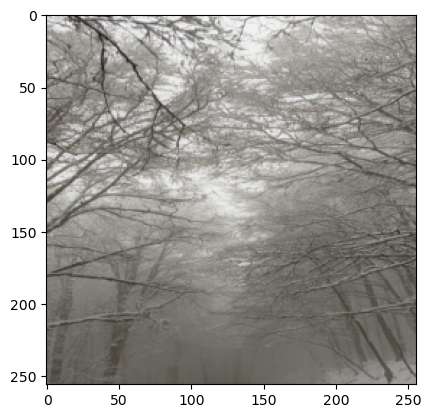

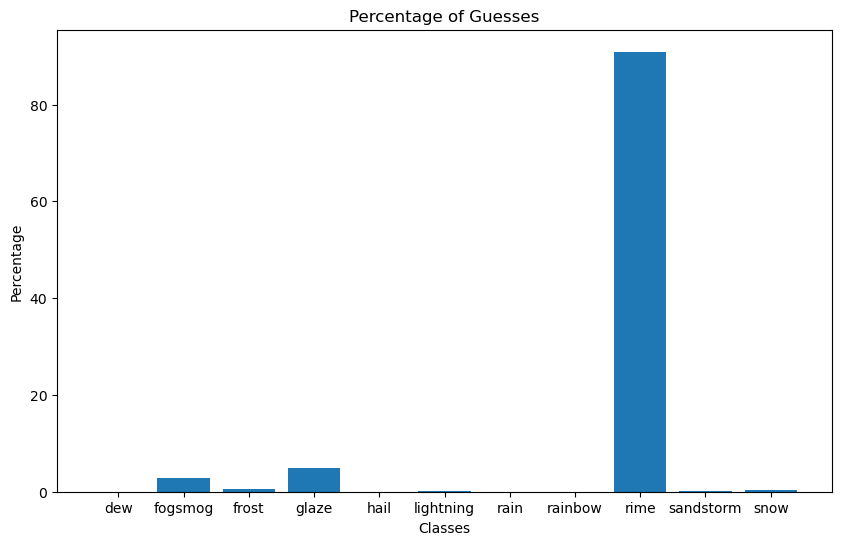

ShuffleNet model prediction: rime
	
Percentage of Guesses:
dew        0.01%
fogsmog    2.78%
frost      0.56%
glaze      5.00%
hail       0.01%
lightning  0.22%
rain       0.00%
rainbow    0.00%
rime       90.92%
sandstorm  0.12%
snow       0.36%
	


In [244]:
custom_img_prediction('7.jpg')

Custom image size: torch.Size([3, 256, 256])
	


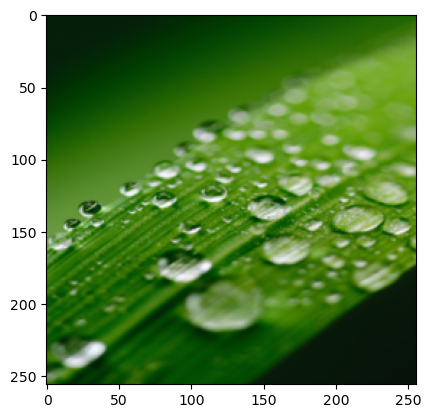

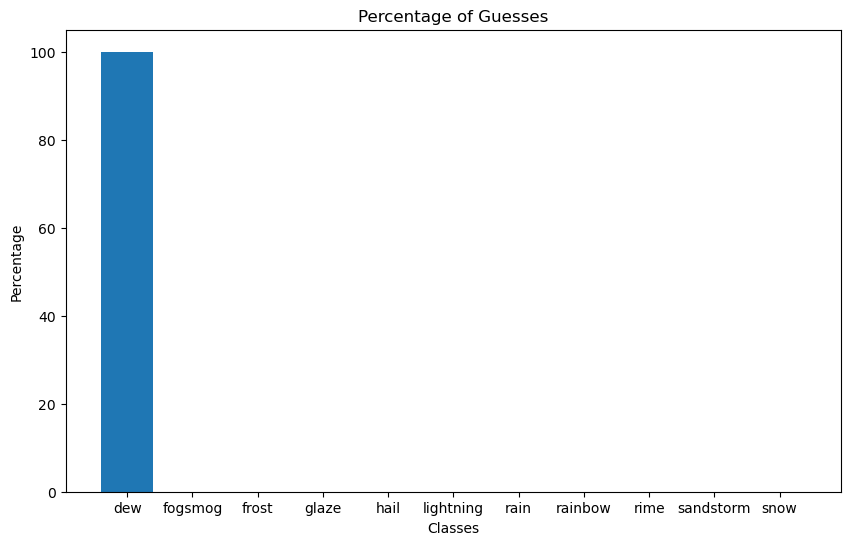

ShuffleNet model prediction: dew
	
Percentage of Guesses:
dew        99.99%
fogsmog    0.00%
frost      0.00%
glaze      0.00%
hail       0.00%
lightning  0.00%
rain       0.00%
rainbow    0.00%
rime       0.00%
sandstorm  0.00%
snow       0.00%
	


In [245]:
custom_img_prediction('2.jpg')

Custom image size: torch.Size([3, 256, 256])
	


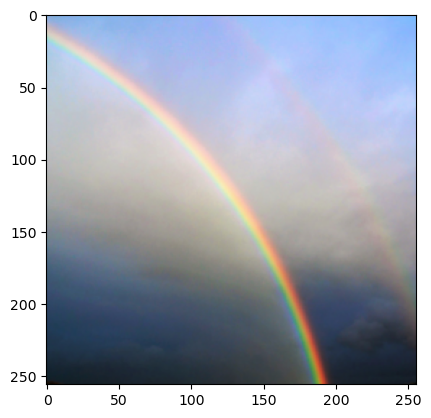

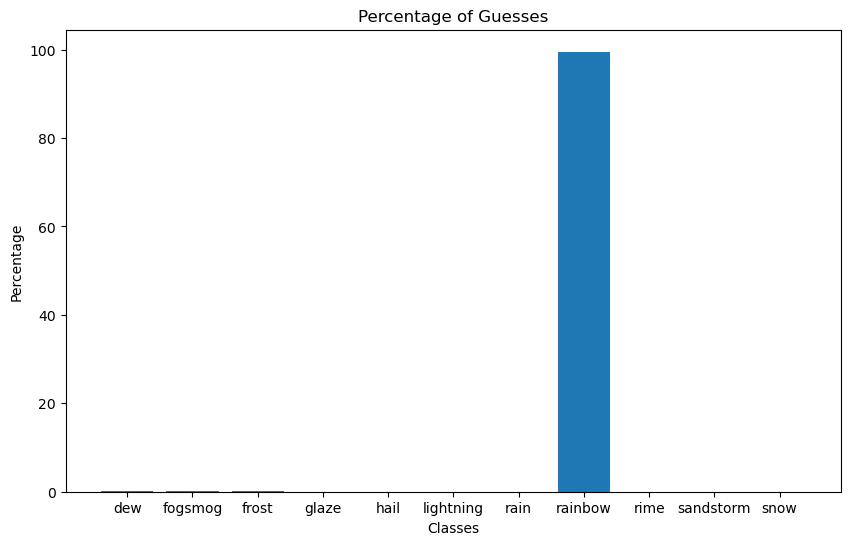

ShuffleNet model prediction: rainbow
	
Percentage of Guesses:
dew        0.06%
fogsmog    0.20%
frost      0.05%
glaze      0.00%
hail       0.02%
lightning  0.04%
rain       0.02%
rainbow    99.53%
rime       0.01%
sandstorm  0.03%
snow       0.04%
	


In [246]:
custom_img_prediction('1.jpg')

Custom image size: torch.Size([3, 256, 256])
	


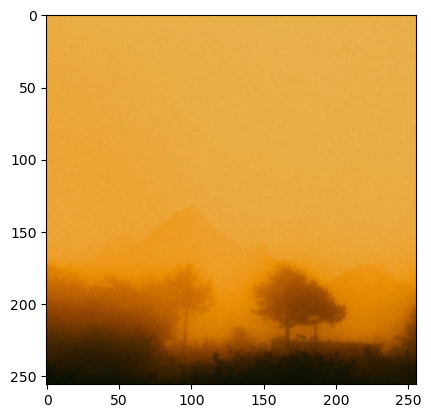

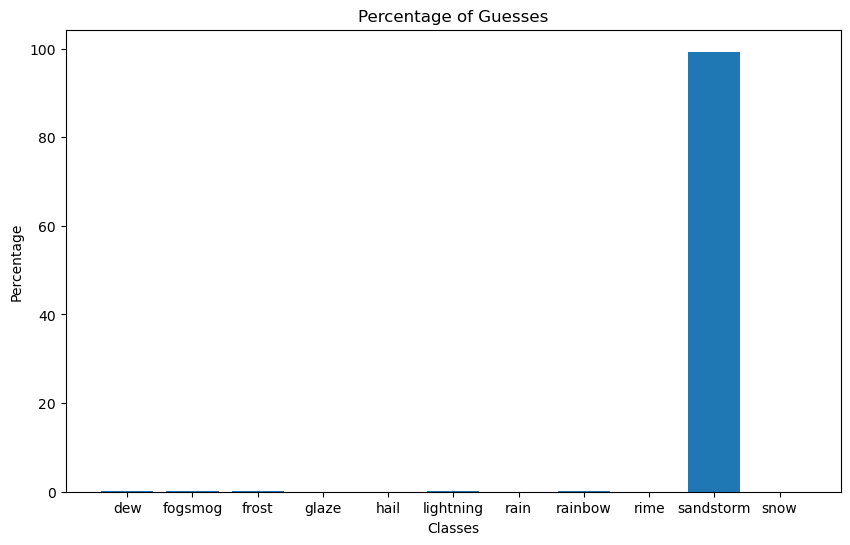

ShuffleNet model prediction: sandstorm
	
Percentage of Guesses:
dew        0.06%
fogsmog    0.10%
frost      0.06%
glaze      0.00%
hail       0.03%
lightning  0.27%
rain       0.01%
rainbow    0.14%
rime       0.02%
sandstorm  99.29%
snow       0.01%
	


In [247]:
custom_img_prediction('3.jpg')

Custom image size: torch.Size([3, 256, 256])
	


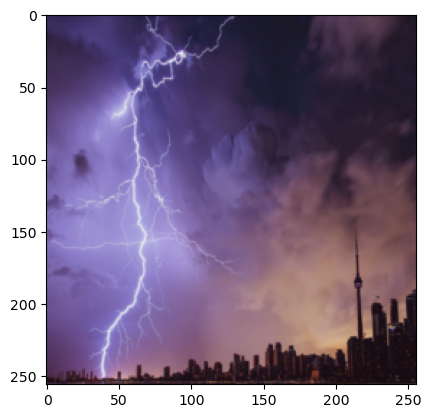

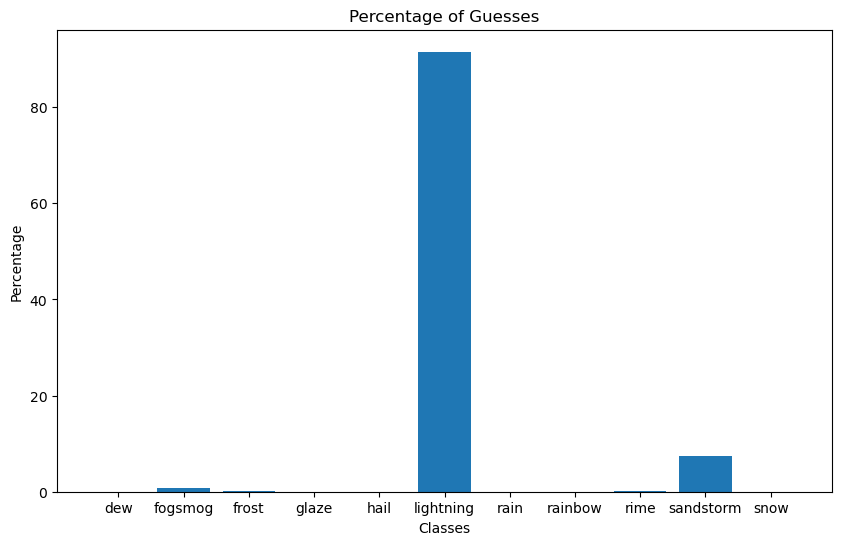

ShuffleNet model prediction: lightning
	
Percentage of Guesses:
dew        0.03%
fogsmog    0.86%
frost      0.10%
glaze      0.01%
hail       0.01%
lightning  91.52%
rain       0.01%
rainbow    0.02%
rime       0.09%
sandstorm  7.35%
snow       0.00%
	


In [248]:
custom_img_prediction('4.jpg')